# Tree Predictors in Scikit-learn
## Guest lecturer: Matteo Bodini

Let's introduce Tree Predictors (a.k.a. Decision Trees) in Scikit-learn. The following topics are included in this notebook:

- Basic visualization of data

- One Hot Encoding

- Modelling a decision tree with default parameters

- Creating a visual tree to present the decision tree

- Results of many decision tree models on an available dataset

- Overfitting control through pre-pruning techniques

## Our case study

We focus on students performance in math exams, and analyze a dataset containing marks obtained by students in college. The goal is to understand the influence of various factors (like economic, personal, social, parents' background and test preparation) on the students performance.

A tree classifier is trained to predict the success in a math exam of a student depending on the above and other features.

The model is first trained by using only default parameters. Then, we see how to reduce overfitting through pre-pruning techniques, which are often used with these models instead of the more standard cross-validation.

## Importing Libraries
We need a couple of additional libraries to display tree classifiers. Graphviz is a tool for drawing graphics and pydotplus is a module to Graphviz’s Dot language. Here are the code lines to install them:
- `conda install python-graphviz`
- `conda install -c conda-forge pydotplus`

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import tree
import graphviz 
import numpy as np
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import pickle

## Loading and Displaying the Dataset

In [2]:
dataset = pd.read_csv("Datasets/StudentsPerformance.csv")
dataset.head()

gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75

## Visualizations

We briefly analyze the dataset using Seaborn, a Python data visualization library based on Matplotlib providing a high-level interface for drawing graphics (https://seaborn.pydata.org).

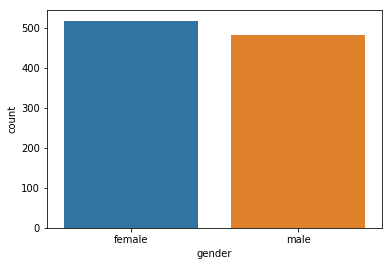

In [3]:
ax = sns.countplot(x="gender", data=dataset)

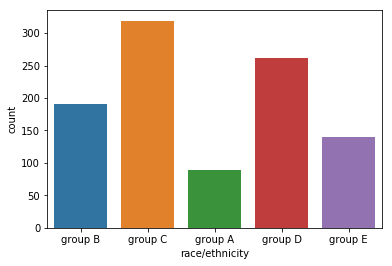

In [4]:
ax = sns.countplot(x="race/ethnicity", data=dataset)

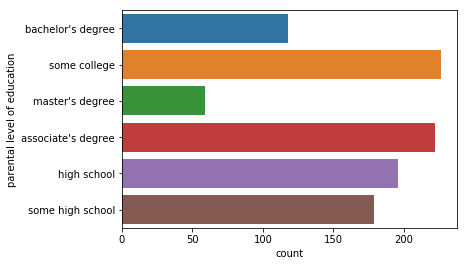

In [5]:
ax = sns.countplot(y="parental level of education", data=dataset)

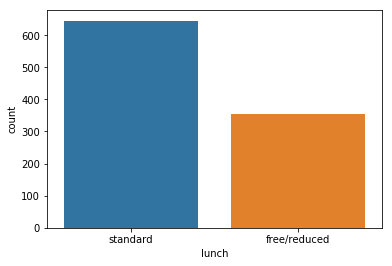

In [6]:
ax = sns.countplot(x="lunch", data=dataset)

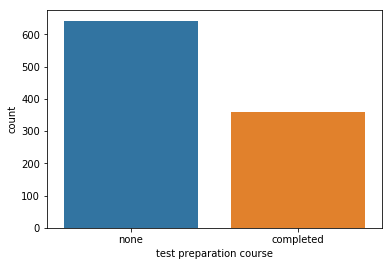

In [7]:
ax = sns.countplot(x="test preparation course", data=dataset)

Finally, we look at the univariate distribution of math scores. A convenient way draw univariate distributions in Seaborn is the `distplot()` function. By default, this draws a histogram and fits a kernel density estimate (KDE is a nonparametric way for estimating the density of a random variable).

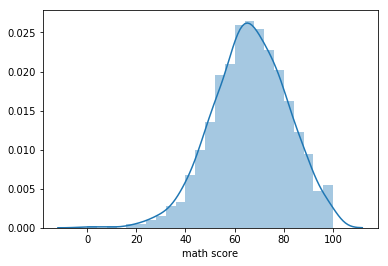

In [8]:
ax = sns.distplot(dataset["math score"])

## Data Processing

Let's create a new feature `math grade`. `math grade` is `Pass` if `math score` is above 60, oterwise it is `Fail`. We the remove the columns used to compute the new feature and check the dataset again.

In [9]:
dataset["math grade"] = ""
dataset.loc[(dataset["math score"] >= 60), "math grade"] = "Pass"
dataset.loc[(dataset["math score"] < 60), "math grade"] = "Fail"
dataset.drop(columns=['math score', 'reading score', 'writing score'], inplace=True)
dataset.head()

gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course math grade  
0                    none       Pass  
1               completed       Pass  
2                    none       Pass  
3                    none       Fail  
4                    none       Pass

## One Hot Encoding

Scikit-learn uses only continuous numerical features.

In our dataset, however, we have categorical features. For example, the `race` feature has values `group A`, `group B`, `group C`, `group D`, and `group E`. Using the standard label encoding, these values are mapped to the integers from $1$ to $5$. This can cause problems because tests based on this feature can only use groupings of `race` values based on the ordering induced by the label encoding. Hence, while `race in {group D, group E}` can be implemented as `race > 2`, `race in {group A, group C}` cannot be implemented.

One-hot encoding solves this problem by associating a new binary feature for each value of the categorical feature. Hence `race` gets replaced by `race_A`, `race_B` and so on until `race_D`. Then the test `race in {group A, group C}` can be implemented using sequences of tests based on `race_A` and `race_D`.

The Pandas function `get_dummies()` whose first argument is a column of a DataFrame (i.e., a Series) creates a new DataFrame with as many binary columns as needed to implement the one-hot encoding of the values found in the column. The flag `drop_first=True` creates $k-1$ binary features $x_1,\ldots,x_{k-1}$ for a categorical feature $x$ with $k$ many distinct values $v_1,\dots,v_k$, where the $(0,\ldots,0)$ one-hot encoding corresponds to $x = v_1$.

Finally, the `join()` method adds the DataFrame with the new columns to the original DataFrame.

In [10]:
one_hot = pd.get_dummies(dataset['gender'], prefix='gender', drop_first=True)
dataset = dataset.join(one_hot)
one_hot = pd.get_dummies(dataset['race/ethnicity'], prefix='race/ethnicity', drop_first=True)
dataset = dataset.join(one_hot)
one_hot = pd.get_dummies(dataset['parental level of education'], prefix='parental level of education', drop_first=True)
dataset = dataset.join(one_hot)
one_hot = pd.get_dummies(dataset['lunch'], prefix='lunch', drop_first=True)
dataset = dataset.join(one_hot)
one_hot = pd.get_dummies(dataset['test preparation course'], prefix='test preparation course', drop_first=True)
dataset = dataset.join(one_hot)
dataset.head()

gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course math grade  gender_male  race/ethnicity_group B  \
0                    none       Pass            0                       1   
1               completed       Pass            0                       0   
2                    none       Pass            0                       1   
3                    none       Fail            1                       0   
4                    none       Pass            1                       0   

   race/ethnicity_group C  race/ethnicity_group D  race/ethnicity_group E  \
0                       0                       0                       0   
1                       1                       0                       0   
2                       0                       0                       0   
3                       0                       0                       0   
4                       1                       0                       0   

   parental level of education_bachelor's degree  \
0                                              1   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   parental level of education_high school  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   parental level of education_master's degree  \
0                                            0   
1                                            0   
2                                            1   
3                                            0   
4                                            0   

   parental level of education_some college  \
0                                         0   
1                                         1   
2                                         0   
3                                         0   
4                                         1   

   parental level of education_some high school  lunch_standard  \
0                                             0               1   
1                                             0               1   
2                                             0               1   
3                                             0               0   
4                                             0               1   

   test preparation course_none  
0                             1  
1                             0  
2                             1  
3                             1  
4                             1

We split the dataset into training and test sets with proportion $70\%$ and $30\%$. 

In [11]:
data_train, data_test = train_test_split(dataset, test_size=0.30, random_state=21)
y_train = data_train["math grade"].values
X_train = data_train.drop(columns=['math grade']).values
y_test = data_test["math grade"].values
X_test = data_test.drop(columns=['math grade']).values

The learning algorithm is initialized with the default values of `DecisionTreeClassifier`.

In [12]:
model = DecisionTreeClassifier(criterion='gini', splitter='best', 
                               max_depth=None, min_samples_split=2, 
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                               max_features=None, random_state=None, 
                               max_leaf_nodes=None, min_impurity_decrease=0.0, 
                               min_impurity_split=None, class_weight=None, 
                               presort=False)

We now run the learning algorithm on the training set.

In [13]:
model.fit(X_train[:,5:], y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Predictions
Next, we use the learned model to predict the points in the test set, compute the accuracy, and print the confusion matrix.

In [14]:
y_pred = model.predict(X_test[:,5:])
print("Model Accuracy: %.2f" % (accuracy_score(y_test,y_pred)*100), "%")
print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test,y_pred),
                   columns=['prediction/fail', 'prediction/pass'],
                   index=['actual/fail', 'actual/pass']))

Model Accuracy: 55.33 %

Confusion Matrix:
             prediction/fail  prediction/pass
actual/fail               39               59
actual/pass               75              127


Model accuracy is $\sim 55\%$. We now compute the training error and compare it with the results from test set. The purpose is to check whether there is an overfitting or not.

In [15]:
y_pred_train = model.predict(X_train[:,5:])

In [16]:
print("Model Accuracy: %.2f" % (accuracy_score(y_train,y_pred_train)*100), "%")

Model Accuracy: 79.86 %


Indeed, $\sim 56\%$ and $\sim 80\%$ are quite different: $\sim 56\%$ is almost a coin flip! On the other hand, $\sim 80\%$ is a promising accuracy rate.

So we are definitely overfitting.

## Graph of Decision Tree

We can simply visualize a decision tree using the Python module ```pydotplus``` and the module ```graphviz```.

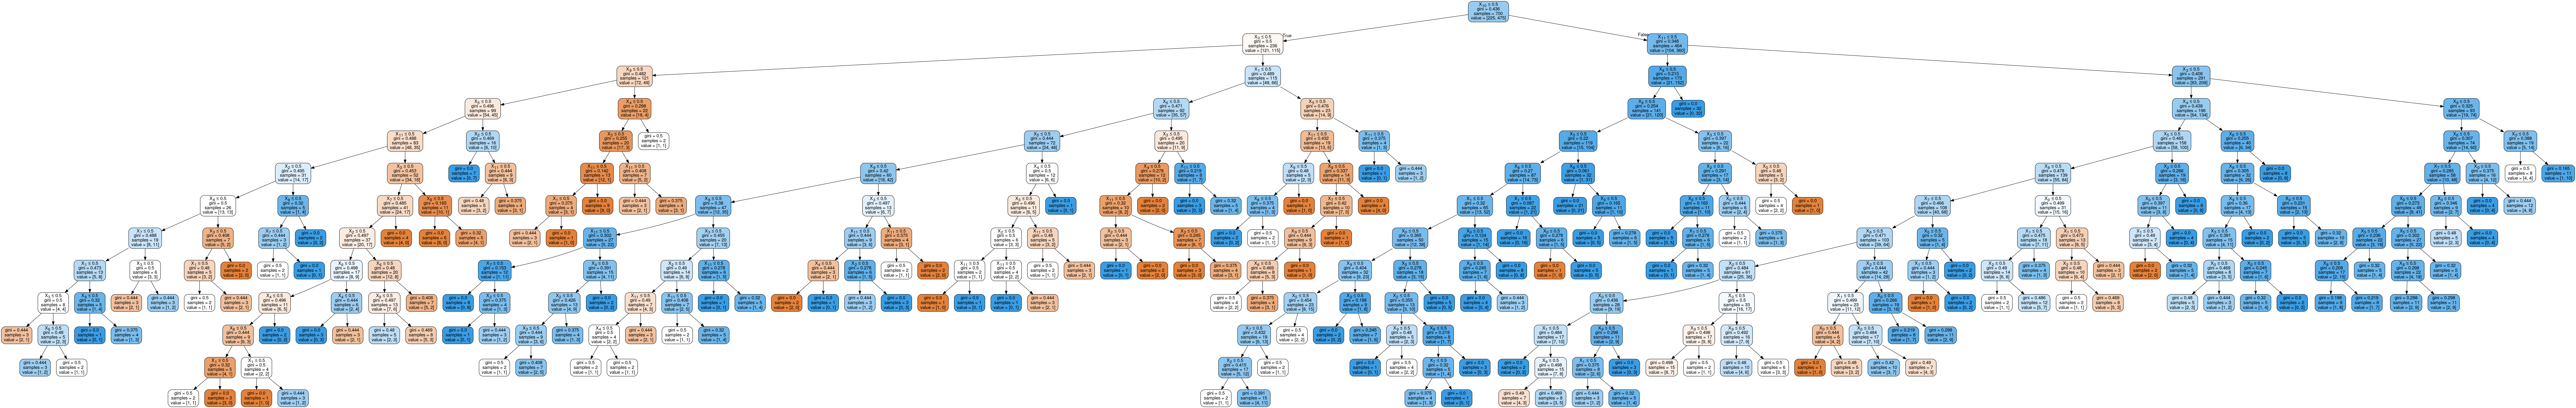

In [17]:
dot_data = StringIO()
export_graphviz(model, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Save and reuse models

After training a Scikit-learn model, it is desirable to have a way to save the model for future use without having to retrain. We can save a model with Pickle (https://docs.python.org/3/library/pickle.html#module-pickle).

Pickle is used for serializing and de-serializing Python object structures. Serialization refers to the process of converting an object in memory to a byte stream that can be stored on disk or sent over a network. Later on, this stream can then be retrieved and de-serialized back to a Python object.

In [18]:
filename = 'saved_model.pickle'
pickle.dump(model, open(filename, 'wb'))

We can now re-load the saved model.

Model Accuracy: 55.33 %


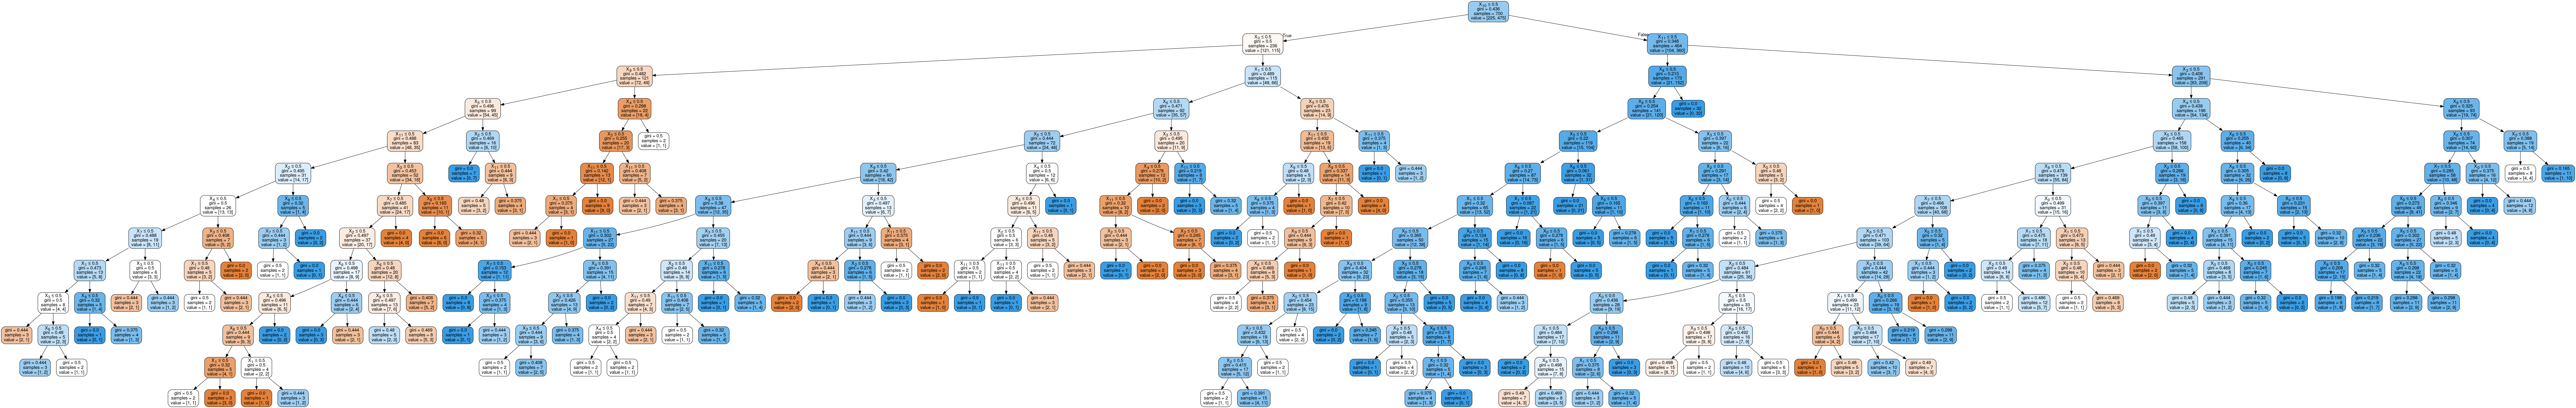

In [19]:
loaded_model = pickle.load(open(filename, 'rb'))
y_pred = loaded_model.predict(X_test[:,5:])
print("Model Accuracy: %.2f" % (accuracy_score(y_test,y_pred)*100), "%")
dot_data = StringIO()
export_graphviz(loaded_model, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# Analysis of Tree Classifier Parameters

We look at some of the parameters for Tree Classifiers.

In order to explore these parameters, we will analyze 8 tree classifier models. 

Recall that the initial model was run with default parameters and had an accuracy of $\sim 55\%$.

In other models we change the following parameters:

- ```max_depth```,
- ```min_samples_split```,
- ```min_samples_leaf```,
- ```max_leaf_nodes```,
- ```gini + min_impurity_decrease```,
- ```entropy + min_impurity_decrease```.

Each parameter's best value brings the model accuracy almost to the same level, $\sim 68\%$. But the sizes of the resulting trees can be quite different.

## Initial model

The first model is trained with default parameters of the learning algorithm. The resulting tree classifier is huge:

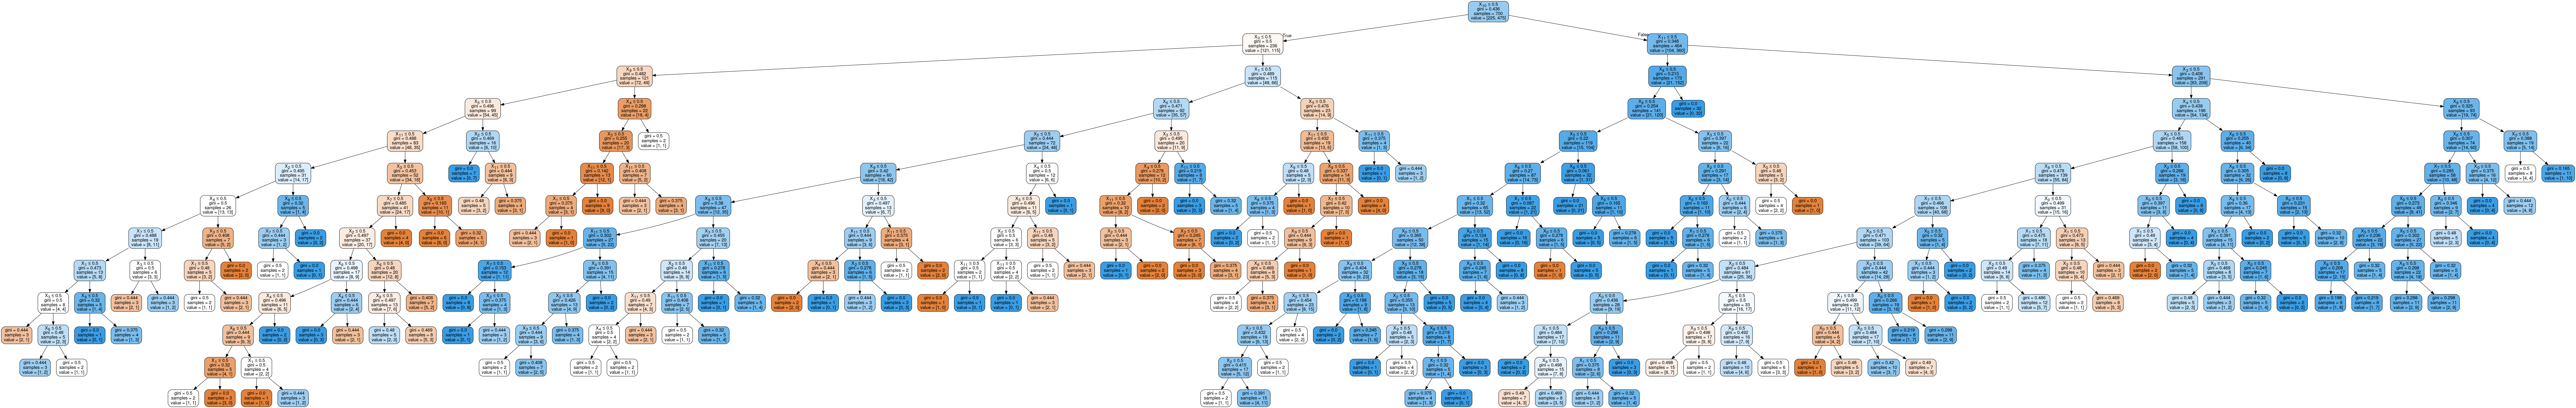

In [20]:
Image(graph.create_png())

This tree pictorially shows the effects of overfitting. Predictions on training set give an accuracy of $\sim 80\%$ vs. a test set accuracy of $\sim 55\%$.

## Model #2

### criterion: string, optional (default=”gini”)
Possible options are "gini" and "entropy". Both indices depend on the leaf purity (predominance of a label over the others among the training examples routed to that leaf). The purer the leaf, the smaller the values of both gini and entropy. Tree algorithms split leaves as long as this value decreases, until it reaches zero or fulfills some stopping criterion. We will only use gini in the rest of this notebook.

### max_depth: int or None, optional (default=None)
The maximum depth of the tree. If `None`, then leaves are expanded until all leaves are pure.

Now we study the effect of changing the maximum depth from $1$ to $15$.

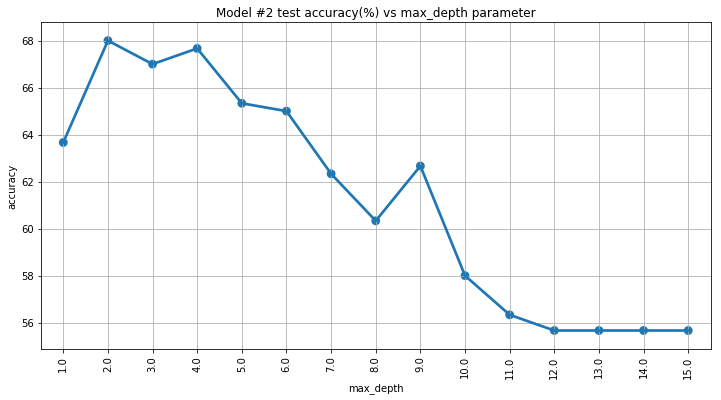

In [21]:
c_parameter_name = 'max_depth'
c_parameter_values = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
c_best_parameter = 0
c_best_accuracy = 0
c_worst_parameter = 0
c_worst_accuracy = 100

df = pd.DataFrame(columns=[c_parameter_name, 'accuracy'])

for input_parameter in c_parameter_values:
    model = DecisionTreeClassifier(criterion='gini', splitter='best', 
                                   max_depth=input_parameter, min_samples_split=2, 
                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                   max_features=None, random_state=21, 
                                   max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                   min_impurity_split=None, class_weight=None, 
                                   presort=False)

    model.fit(X_train[:,5:], y_train)
    y_pred = model.predict(X_test[:,5:])
    acc_score = accuracy_score(y_test,y_pred)*100
    df = df.append({c_parameter_name : input_parameter , 'accuracy' : acc_score}, ignore_index=True)
    if acc_score > c_best_accuracy:
        c_best_accuracy = acc_score
        c_best_parameter = input_parameter
        c_best_model = model
    if acc_score < c_worst_accuracy:
        c_worst_accuracy = acc_score
        c_worst_parameter = input_parameter
        c_worst_model = model

plt.figure(figsize=(12,6))
sns.pointplot(x=c_parameter_name, y="accuracy", data=df)
title = 'Model #2 test accuracy(%) vs ' + c_parameter_name + ' parameter'
plt.title(title)
plt.xticks(rotation= 90)
plt.grid()

BEST PERFORMANCE TREE, max_depth = 2 , accuracy = 68.00


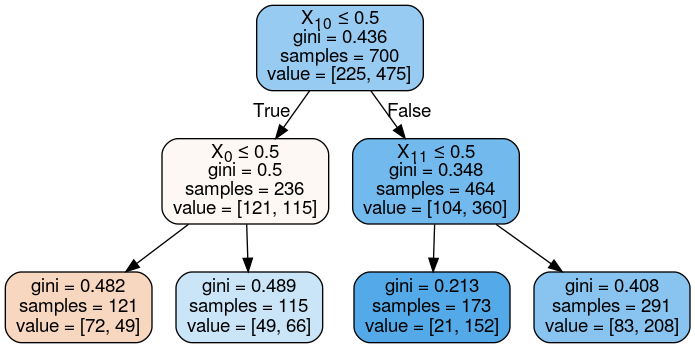

In [22]:
print("BEST PERFORMANCE TREE,", c_parameter_name, "=", c_best_parameter, ", accuracy = %.2f" % (c_best_accuracy))
dot_data = StringIO()
export_graphviz(c_best_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Highest accuracy is achieved for ```max_depth=2```.

The accuracy vs. ```max_depth``` plot tells us that, whenever training accuracy does not change much with the depth, then test accuracy decreases with the increase of depth, so that lower depth models exhibit smaller risks than higher depth models.

Clearly, in order to avoid underfitting we should let the tree depth increase until the training accuracy is small enough.

## Model #3

### min_samples_split : int, float, optional (default=2)
This is the minimum number of examples required to split a node. If this parameter is set to 20, then any leaf which has less than 20 training examples routed to it will not be split.

We explore values of this parameter from $5$ to $400$.

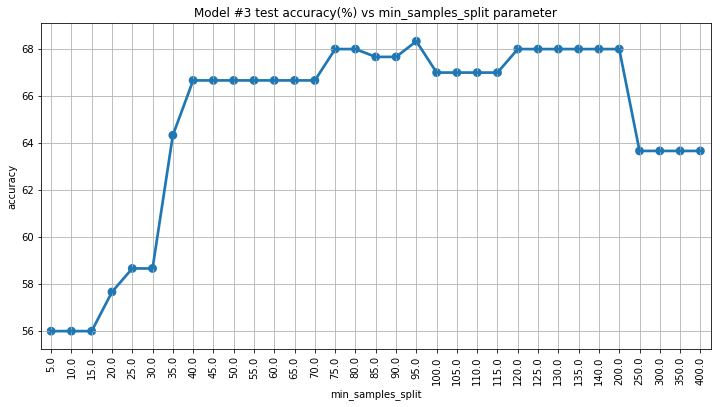

In [23]:
c_parameter_name = 'min_samples_split'
c_parameter_values = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,
                      100,105,110,115,120,125,130,135,140,200,250,300,350,400]
c_best_parameter = 0
c_best_accuracy = 0
c_worst_parameter = 0
c_worst_accuracy = 100

df = pd.DataFrame(columns=[c_parameter_name, 'accuracy'])

for input_parameter in c_parameter_values:
    model = DecisionTreeClassifier(min_samples_split=input_parameter, random_state=21)

    model.fit(X_train[:,5:], y_train)

    y_pred = model.predict(X_test[:,5:])
    
    acc_score = accuracy_score(y_test,y_pred)*100
    
    df = df.append({c_parameter_name : input_parameter , 'accuracy' : acc_score}, ignore_index=True)
    
    if acc_score > c_best_accuracy:
        c_best_accuracy = acc_score
        c_best_parameter = input_parameter
        c_best_model = model
        
    if acc_score < c_worst_accuracy:
        c_worst_accuracy = acc_score
        c_worst_parameter = input_parameter
        c_worst_model = model

plt.figure(figsize=(12,6))
sns.pointplot(x=c_parameter_name, y="accuracy", data=df)
title = 'Model #3 test accuracy(%) vs ' + c_parameter_name + ' parameter'
plt.title(title)
plt.xticks(rotation= 90)
plt.grid()

BEST PERFORMANCE TREE, min_samples_split = 95 , accuracy = 68.33


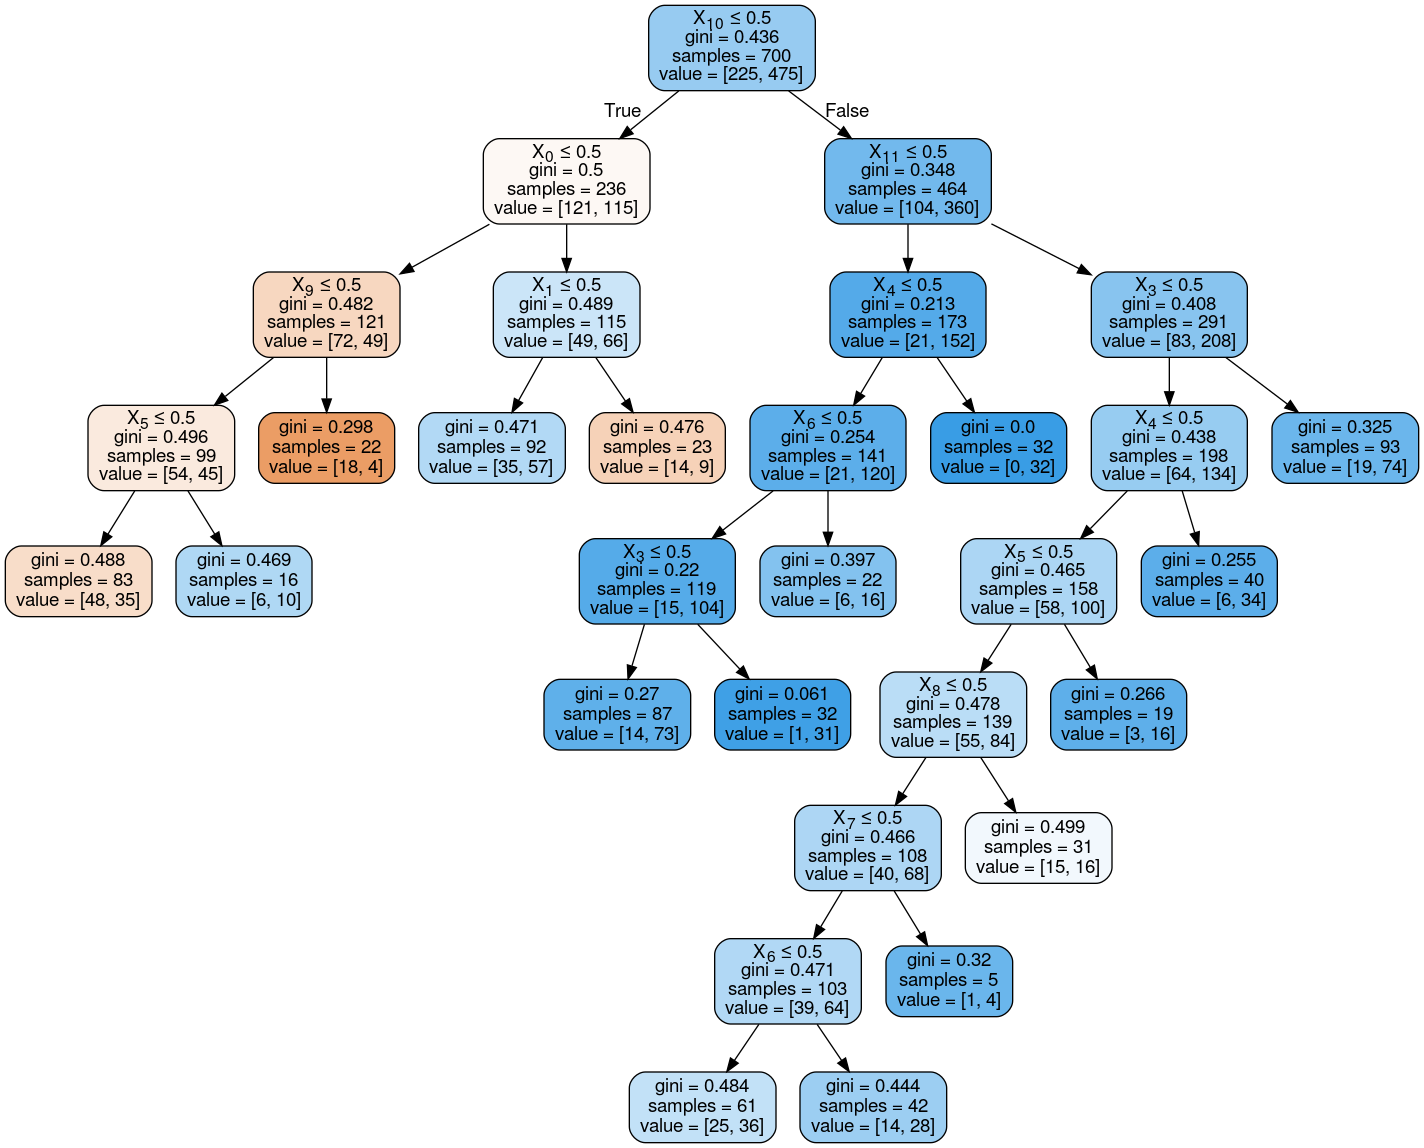

In [24]:
print("BEST PERFORMANCE TREE,", c_parameter_name, "=", c_best_parameter, ", accuracy = %.2f" % (c_best_accuracy))
dot_data = StringIO()
export_graphviz(c_best_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

The final test accuracy is similar to the one we got by tuning ```max_depth```.

Any value for `min_samples_split` between $40$ and $200$ looks OK. Overfitting starts at values below $40$.

## Model #4

### min_samples_leaf : int, float, optional (default=1)
The minimum number of training examples required to create a new leaf.

We explore values from $5$ to $200$.

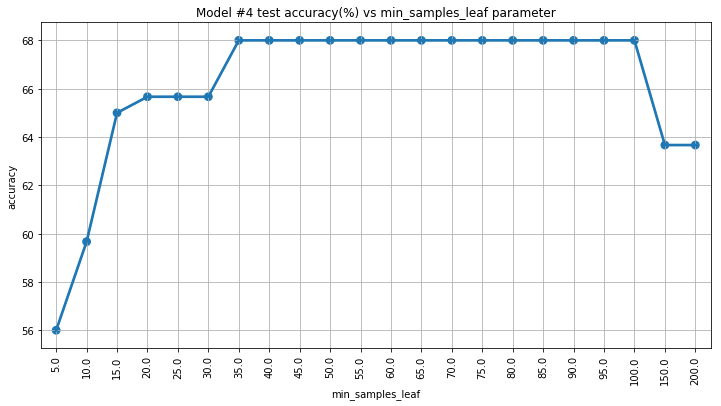

In [25]:
c_parameter_name = 'min_samples_leaf'
c_parameter_values = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,150,200]
c_best_parameter = 0
c_best_accuracy = 0
c_worst_parameter = 0
c_worst_accuracy = 100

df = pd.DataFrame(columns=[c_parameter_name, 'accuracy'])

for input_parameter in c_parameter_values:
    model = DecisionTreeClassifier(min_samples_leaf=input_parameter, random_state=21)

    model.fit(X_train[:,5:], y_train)

    y_pred = model.predict(X_test[:,5:])
    
    acc_score = accuracy_score(y_test,y_pred)*100
    
    df = df.append({c_parameter_name : input_parameter , 'accuracy' : acc_score}, ignore_index=True)
    
    if acc_score > c_best_accuracy:
        c_best_accuracy = acc_score
        c_best_parameter = input_parameter
        c_best_model = model
        
    if acc_score < c_worst_accuracy:
        c_worst_accuracy = acc_score
        c_worst_parameter = input_parameter
        c_worst_model = model

plt.figure(figsize=(12,6))
sns.pointplot(x=c_parameter_name, y="accuracy", data=df)
title = 'Model #4 test accuracy(%) vs ' + c_parameter_name + ' parameter'
plt.title(title)
plt.xticks(rotation= 90)
plt.grid()

BEST PERFORMANCE TREE, min_samples_leaf = 35 , accuracy = 68.00


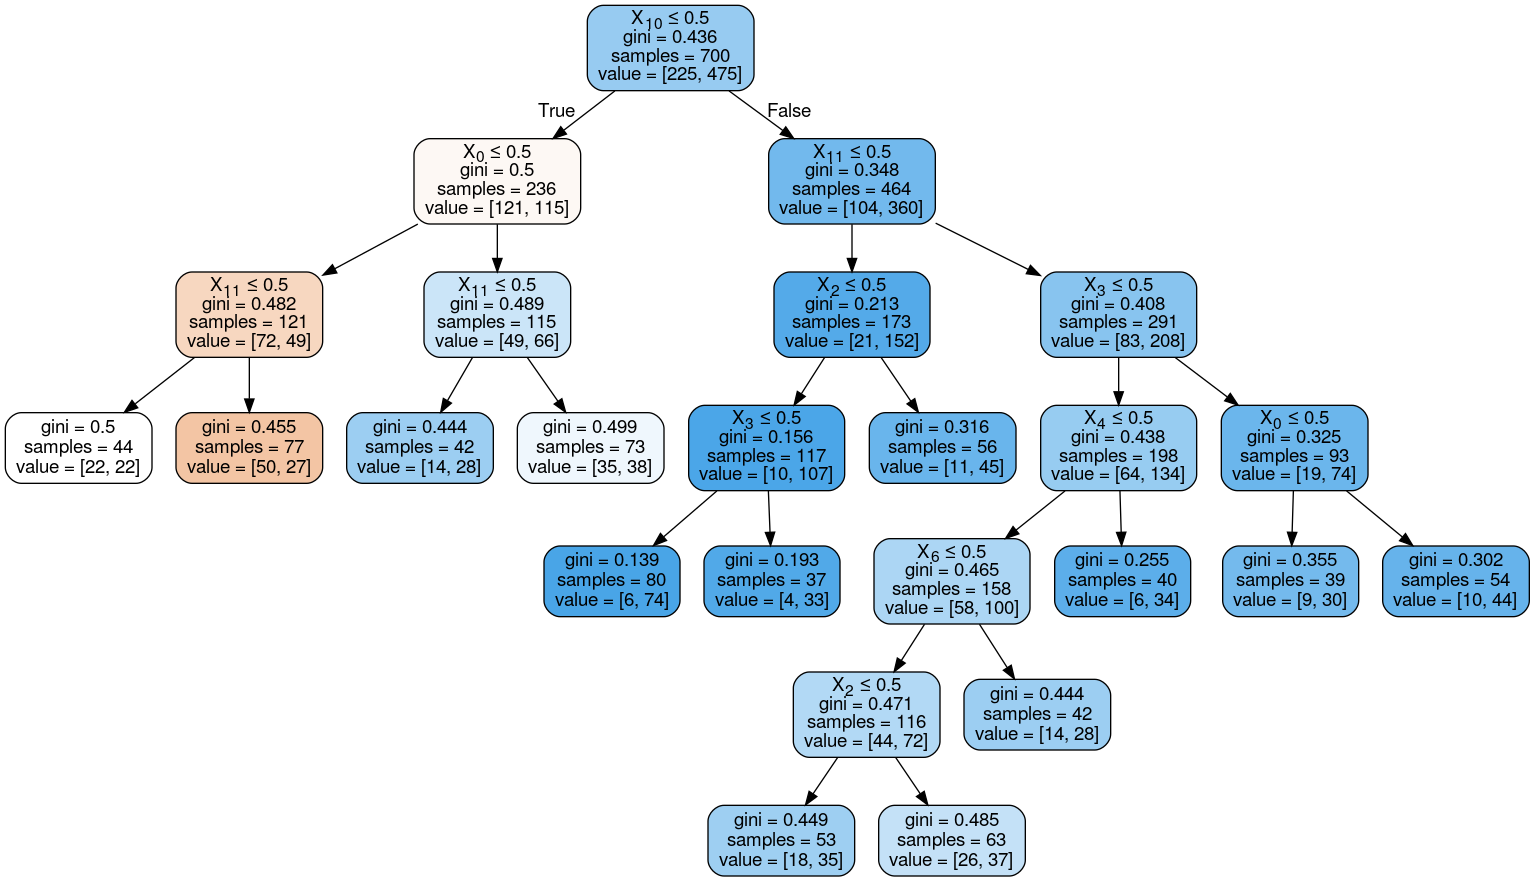

In [26]:
print("BEST PERFORMANCE TREE,", c_parameter_name, "=", c_best_parameter, ", accuracy = %.2f" % (c_best_accuracy))
dot_data = StringIO()
export_graphviz(c_best_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

We do not see a big difference in performance. Values of ```min_samples_leaf``` between $35$ and $100$ look all OK.

## Model #5

### max_leaf_nodes : int or None, optional (default=None)
Maximum number of leaves in a tree.

We limit this number to values between $2$ and $20$.

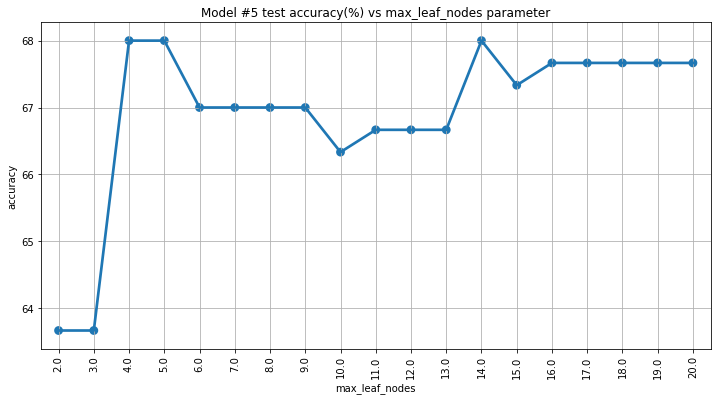

In [27]:
c_parameter_name = 'max_leaf_nodes'
c_parameter_values = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
c_best_parameter = 0
c_best_accuracy = 0
c_worst_parameter = 0
c_worst_accuracy = 100

df = pd.DataFrame(columns=[c_parameter_name, 'accuracy'])

for input_parameter in c_parameter_values:
    model = DecisionTreeClassifier(max_leaf_nodes=input_parameter, random_state=21)

    model.fit(X_train[:,5:], y_train)

    y_pred = model.predict(X_test[:,5:])
    
    acc_score = accuracy_score(y_test,y_pred)*100
    
    df = df.append({c_parameter_name : input_parameter , 'accuracy' : acc_score}, ignore_index=True)
    
    if acc_score > c_best_accuracy:
        c_best_accuracy = acc_score
        c_best_parameter = input_parameter
        c_best_model = model
        
    if acc_score < c_worst_accuracy:
        c_worst_accuracy = acc_score
        c_worst_parameter = input_parameter
        c_worst_model = model

plt.figure(figsize=(12,6))
sns.pointplot(x=c_parameter_name, y="accuracy", data=df)
title = 'Model #5 test accuracy(%) vs ' + c_parameter_name + ' parameter'
plt.title(title)
plt.xticks(rotation= 90)
plt.grid()

BEST PERFORMANCE TREE, max_leaf_nodes = 4 , accuracy = 68.00


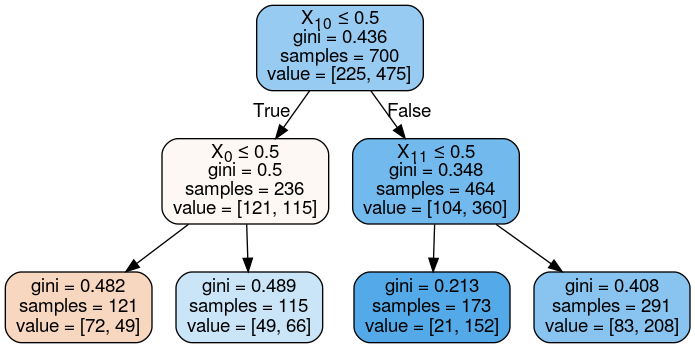

In [28]:
print("BEST PERFORMANCE TREE,", c_parameter_name, "=", c_best_parameter, ", accuracy = %.2f" % (c_best_accuracy))
dot_data = StringIO()
export_graphviz(c_best_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Note that there are two maxima. One at ```max_leaf_nodes=4``` and one at ```max_leaf_nodes=14```.


## Model #6

### min_impurity_decrease : float, optional (default=0.)
One of the most effective parameters. Either gini or entropy is used to calculate the purity of a split.

Suppose there are $100$ training examples, and $20$ of them are routed to the leaf we are considering to split, of these $20$ examples $12$ are positive and $8$ are negative. 

- Step 1: calculate gini for the leaf:

$$\text{Fraction of positives} = 12 / 20 = 0.6$$
$$\text{Fraction of negatives} = 8 / 20 = 0.4$$
$$G = 0.6 \times 0.4 + 0.4 \times 0.6 = 0.48$$

- Step 2: suppose that by splitting the leaf using a specific feature, $13$ examples ($11$ yes and $2$ no) are routed to the left child, and $7$ examples ($1$ positive and $6$ negative) are routed to the right child.

Left child:
$$\text{Fraction of positives} = 11 / 13 = 0.85$$
$$\text{Fraction of negatives} = 2 / 13 = 0.15$$
$$G_{left} = 0.85 \times 0.15 + 0.15 \times 0.85 = 0.255$$
Right child: 
$$\text{Fraction of positives} = 6 / 7 = 0.86$$
$$\text{Fraction of negatives} = 1 / 7 = 0.14$$
$$G_{right} = 0.86 \times 0.14 + 0.14 \times 0.86 = 0.241$$

- Step 3: calculate the weighted decrease of gini:
$N_t / N \times (G - N_{t_R} / N_t \times G_{right} - N_{t_L} / N_t \times G_{left})$
where $N$ is the total number of examples, $N_t$ is the number of examples at the current leaf, $N_{t_L}$ is the number of examples in the left child, and $N_{t_R}$ is the number of examples in the right child.
$$20 / 100 \times (0.48 - 7 / 20 \times 0.241 - 13 / 20 \times 0.255) = 0.046$$

- Step 4: If the biggest decrease in gini over all possible features is bigger than ```min_impurity_decrease```, then the leaf is split using the feature maximizing the decrease.

When there are no more possible splits achieving a decrease in gini bigger than `min_impurity_decrease`, then the tree stops growing.

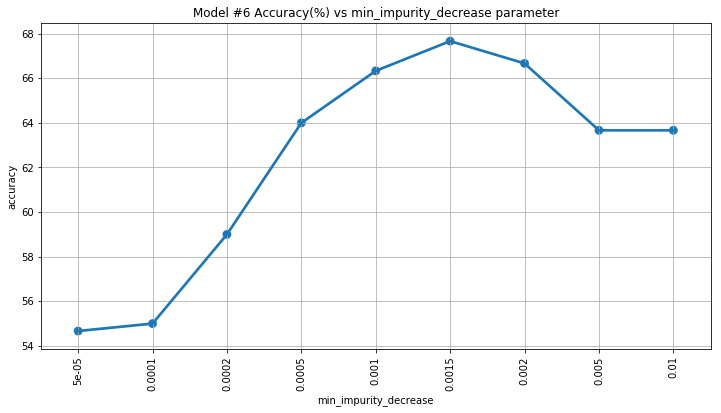

In [29]:
c_parameter_name = 'min_impurity_decrease'
c_parameter_values = [0.00005,0.0001,0.0002,0.0005,0.001,0.0015,0.002,0.005,0.01]
c_best_parameter = 0
c_best_accuracy = 0
c_worst_parameter = 0
c_worst_accuracy = 100

df = pd.DataFrame(columns=[c_parameter_name, 'accuracy'])

for input_parameter in c_parameter_values:
    model = DecisionTreeClassifier(min_impurity_decrease=input_parameter, random_state=21)

    model.fit(X_train[:,5:], y_train)

    y_pred = model.predict(X_test[:,5:])
    
    acc_score = accuracy_score(y_test,y_pred)*100
    
    df = df.append({c_parameter_name : input_parameter , 'accuracy' : acc_score}, ignore_index=True)
    
    if acc_score > c_best_accuracy:
        c_best_accuracy = acc_score
        c_best_parameter = input_parameter
        c_best_model = model
        
    if acc_score < c_worst_accuracy:
        c_worst_accuracy = acc_score
        c_worst_parameter = input_parameter
        c_worst_model = model

plt.figure(figsize=(12,6))
sns.pointplot(x=c_parameter_name, y="accuracy", data=df)
title = 'Model #6 Accuracy(%) vs ' + c_parameter_name + ' parameter'
plt.title(title)
plt.xticks(rotation= 90)
plt.grid()

BEST PERFORMANCE TREE, min_impurity_decrease = 0.0015 , accuracy = 67.67


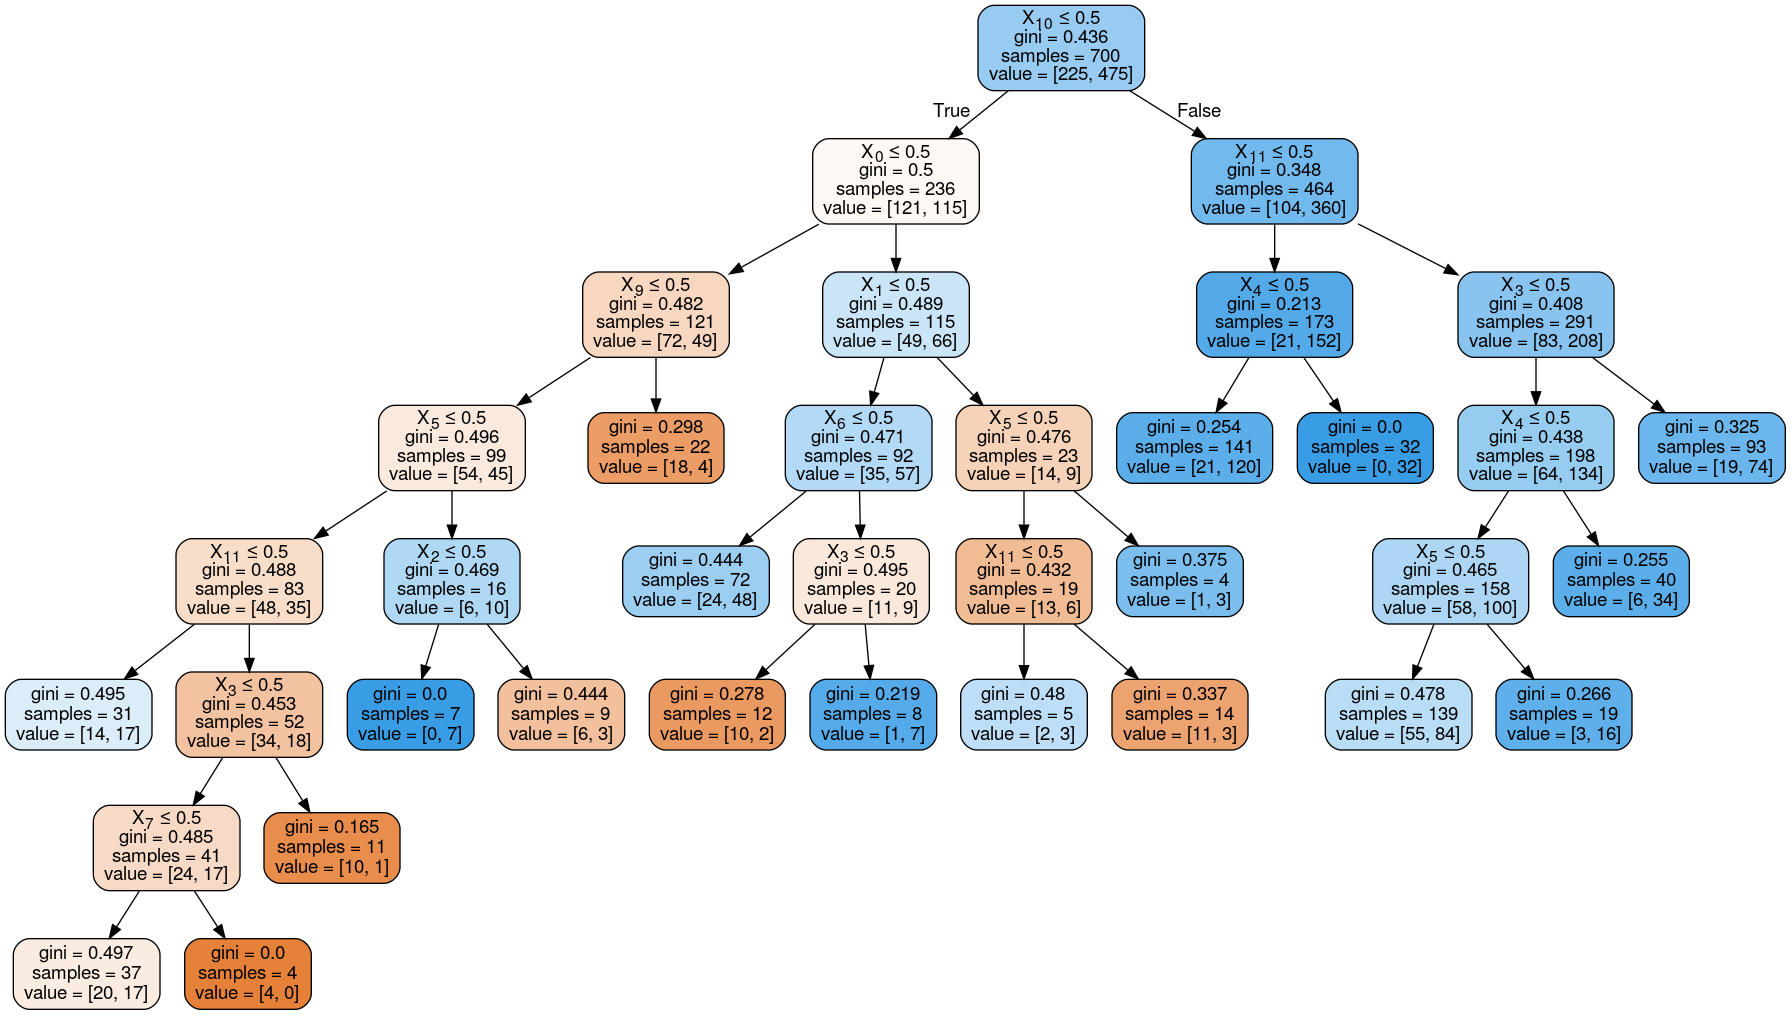

In [30]:
print("BEST PERFORMANCE TREE,", c_parameter_name, "=", c_best_parameter, ", accuracy = %.2f" % (c_best_accuracy))
dot_data = StringIO()
export_graphviz(c_best_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

There is no improvement. On the other hand, ```min_impurity_decrease``` is somewhat more reliable than other parameters.

What can we do more? We can try entropy as criterion as opposed to gini.

### Model #7

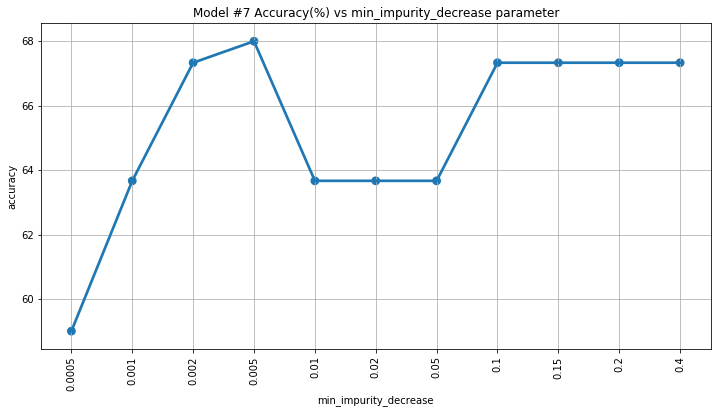

In [31]:
c_parameter_name = 'min_impurity_decrease'
c_parameter_values = [0.0005,0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.15,0.2,0.4]
c_best_parameter = 0
c_best_accuracy = 0
c_worst_parameter = 0
c_worst_accuracy = 100

df = pd.DataFrame(columns=[c_parameter_name, 'accuracy'])

for input_parameter in c_parameter_values:
    model = DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=input_parameter, random_state=21)

    model.fit(X_train[:,5:], y_train)

    y_pred = model.predict(X_test[:,5:])
    
    acc_score = accuracy_score(y_test,y_pred)*100
    
    df = df.append({c_parameter_name : input_parameter , 'accuracy' : acc_score}, ignore_index=True)
    
    if acc_score > c_best_accuracy:
        c_best_accuracy = acc_score
        c_best_parameter = input_parameter
        c_best_model = model
        
    if acc_score < c_worst_accuracy:
        c_worst_accuracy = acc_score
        c_worst_parameter = input_parameter
        c_worst_model = model

plt.figure(figsize=(12,6))
sns.pointplot(x=c_parameter_name, y="accuracy", data=df)
title = 'Model #7 Accuracy(%) vs ' + c_parameter_name + ' parameter'
plt.title(title)
plt.xticks(rotation= 90)
plt.grid()

BEST PERFORMANCE TREE, min_impurity_decrease = 0.005 , accuracy = 68.00


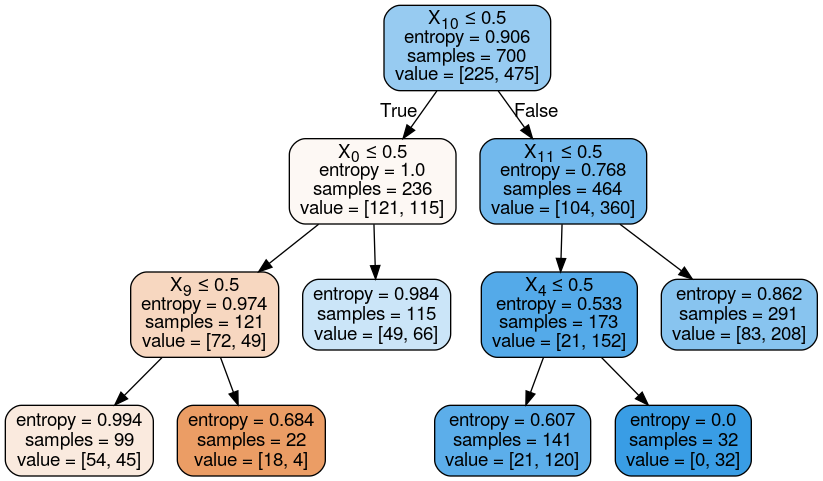

In [32]:
print("BEST PERFORMANCE TREE,", c_parameter_name, "=", c_best_parameter, ", accuracy = %.2f" % (c_best_accuracy))
dot_data = StringIO()
export_graphviz(c_best_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Entropy gives results similar to gini.

We can try a last model combining some of the parameters we have used in our previous models.

## Model #8

Since entropy gives slightly better results than gini, we choose entropy for impurity calculations. The other two parameters are ```min_samples_leaf``` and ```min_impurity_decrease```. We choose the best values for these parameters basd on our previous experiments.

* Set criterion='entropy'
* Set min_samples_leaf=35
* Set min_impurity_decrease=0.005

Model Accuracy: 68.00 %


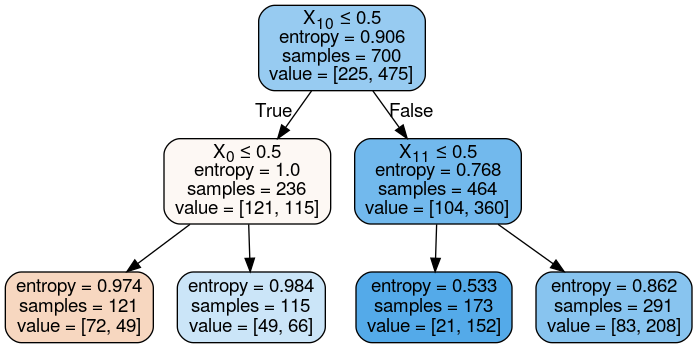

In [33]:
model = DecisionTreeClassifier(criterion='entropy', splitter='best', 
                               max_depth=None, min_samples_split=2, 
                               min_samples_leaf=35, min_weight_fraction_leaf=0.0, 
                               max_features=None, random_state=21, 
                               max_leaf_nodes=None, min_impurity_decrease=0.005, 
                               min_impurity_split=None, class_weight=None, 
                               presort=False)

model.fit(X_train[:,5:], y_train)

y_pred = model.predict(X_test[:,5:])
print("Model Accuracy: %.2f" % (accuracy_score(y_test,y_pred)*100), "%")

dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

There is no improvement in accuracy, however:

- usually, smaller trees are preferrable: smaller trees typically have lower variance and better generalization capability.
- using ```min_impurity_decrease``` in tree classifiers we let the tree grow only if there is room for improvement. This is reasonable compared to other pre-pruning criteria.
- Using ```min_samples_leaf``` with ```min_impurity_decrease``` is a good combination. Even if there is room to go further, the tree is stopped before creating leaves based on a very small number of training examples.